Dervla Gargan - 22346279
Mark Langtry - 22340475
Amy McMahon - 22346619

Code executed without errors :)

**Links used**

In [51]:
import gym
import tensorflow as tf
from collections import deque
import numpy as np

env = gym.make('MountainCar-v0', render_mode="rgb_array")

In [52]:
obs, info = env.reset(seed=42)
obs

array([-0.4452088,  0.       ], dtype=float32)

In [53]:
space = env.observation_space
actions = env.action_space

In [54]:
tf.random.set_seed(42)  
input_shape = space.shape  
n_outputs = actions.n  

model = tf.keras.Sequential([
    tf.keras.layers.Dense(24, activation="relu", input_shape=input_shape),
    tf.keras.layers.Dense(48, activation="relu"),
    tf.keras.layers.Dense(n_outputs, activation="linear")
    
])

In [55]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)  # random action
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()  # optimal action according to the DQN

In [56]:
replay_buffer = deque(maxlen=2000)

class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = np.empty(max_size, dtype=object)
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = np.random.randint(self.size, size=batch_size)
        return self.buffer[indices]

In [57]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]  

In [58]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

In [59]:
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
best_score = 0

In [60]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [61]:
rewards = []
for episode in range(250):
    reward_actual  = 0 
    obs, info = env.reset()    
    for step in range(250):
        epsilon = max(1 - episode / 250, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        reward_actual += reward
        if done or truncated:
            break
        
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(reward_actual)
    if step <= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)


Episode: 25, Steps: 200, eps: 0.880

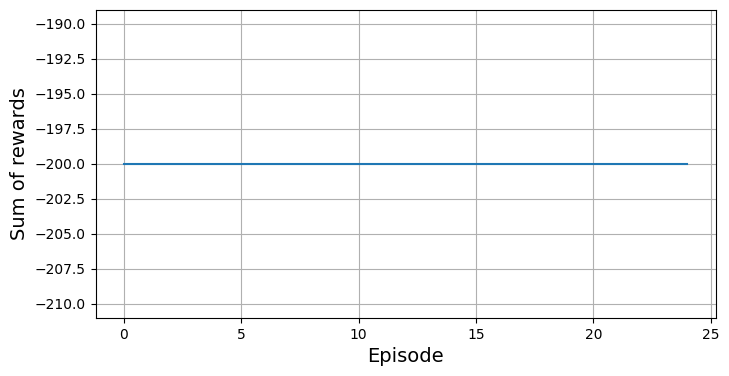

In [62]:
import matplotlib.pyplot as plt

# extra code – this cell generates and saves Figure 18–10
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()